In [ ]:
xpip install pandas rapidfuzz rouge seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.1 MB/s eta 0:00:00


True
Tesla T4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading dataset from: /content/drive/My Drive/Dissertation/cuad_qa_dataset.json


Device set to use cuda:0
Device set to use cuda:0
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
Device set to use cuda:0


Running experiments for model: Jasu/legalbert


Processing test examples: 100%|██████████| 2000/2000 [06:16<00:00,  5.31it/s]


Running experiments for model: deepset/roberta-squad2


Processing test examples: 100%|██████████| 2000/2000 [06:12<00:00,  5.36it/s]


Running experiments for model: nlpaueb/legal-bert-base-uncased


Processing test examples: 100%|██████████| 2000/2000 [06:29<00:00,  5.14it/s]


Running experiments for model: atharvamundada99/bert-large-qa-legal


Processing test examples: 100%|██████████| 2000/2000 [10:49<00:00,  3.08it/s]


Average time per model (in seconds): {'Jasu/legalbert': 0.05615193140506745, 'deepset/roberta-squad2': 0.058614185214042665, 'nlpaueb/legal-bert-base-uncased': 0.05708247542381287, 'atharvamundada99/bert-large-qa-legal': 0.18461660647392272}


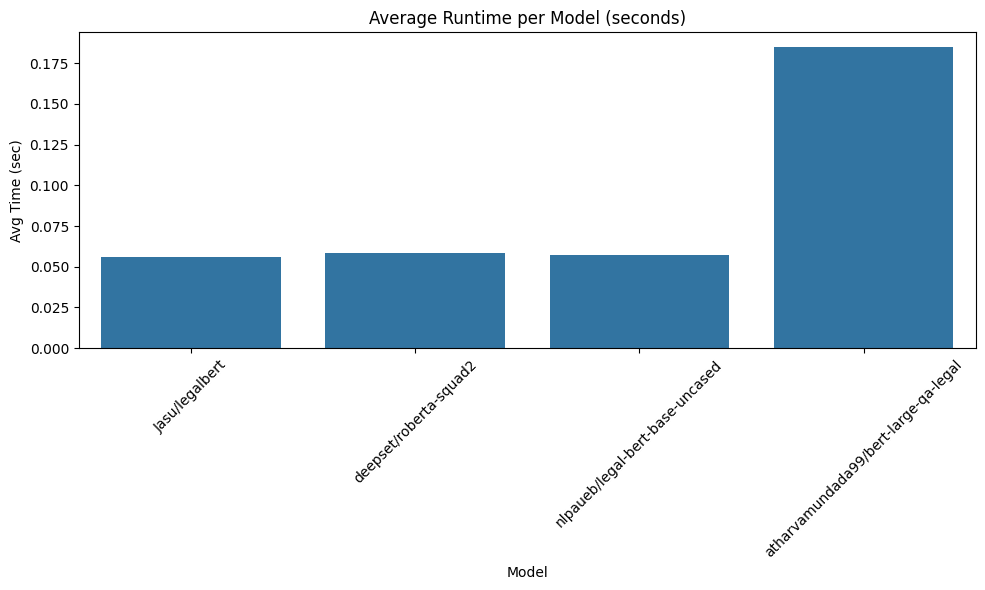

CUAD test experiment complete.


In [ ]:
import re, string
import json
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from sentence_transformers import SentenceTransformer, util  # for semantic similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rouge import Rouge
import time
import torch

print(torch.cuda.is_available())  # Should be True if a GPU is available
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

# ============================
# 1. MOUNT GOOGLE DRIVE & LOAD DATASET
# ============================
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/My Drive/Dissertation/cuad_qa_dataset.json"
print("Loading dataset from:", dataset_path)
with open(dataset_path, "r") as f:
    data = json.load(f)
test_examples = data["test"][:2000]

# ============================================================================
# 2. Define Helper Functions (Normalization, Metrics, Chunking, TF-IDF Retrieval)
# ============================================================================

def normalize_text(text):
    """Lowercase, remove punctuation, collapse whitespace."""
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

def compute_em(prediction, gold):
    """Exact match: 1 if normalized prediction equals normalized gold, else 0."""
    return 1 if normalize_text(prediction) == normalize_text(gold) else 0

def compute_f1(prediction, gold):
    """Token-level F1 between prediction and gold."""
    pred_tokens = normalize_text(prediction).split()
    gold_tokens = normalize_text(gold).split()
    common = set(pred_tokens) & set(gold_tokens)
    if len(common) == 0:
        return 0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(gold_tokens)
    return 2 * (precision * recall) / (precision + recall)

def compute_partial_f1(prediction, gold):
    """Partial F1 as overlap tokens divided by average token count."""
    pred_tokens = normalize_text(prediction).split()
    gold_tokens = normalize_text(gold).split()
    common = set(pred_tokens) & set(gold_tokens)
    if len(common) == 0:
        return 0
    avg_len = (len(pred_tokens) + len(gold_tokens)) / 2.0
    return len(common) / avg_len

# Semantic similarity via SentenceTransformers
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
def compute_semantic_similarity(prediction, gold):
    pred_emb = semantic_model.encode(normalize_text(prediction))
    gold_emb = semantic_model.encode(normalize_text(gold))
    return util.cos_sim(pred_emb, gold_emb).item()

rouge = Rouge()
def compute_rouge(prediction, gold):
    pred_norm = normalize_text(prediction)
    gold_norm = normalize_text(gold)
    if not pred_norm or not gold_norm:
        return 0
    try:
        scores = rouge.get_scores(pred_norm, gold_norm)
        return scores[0]['rouge-l']['f']
    except ValueError as e:
        print(f"ROUGE computation failed: {e}")
        return 0

# Chunking: Split context into overlapping chunks (max_tokens default ~512)
def chunk_text(text, tokenizer, max_tokens=512, overlap=50):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = []
    start = 0
    while start < len(tokens):
        end = min(start + max_tokens, len(tokens))
        chunk_tokens = tokens[start:end]
        chunk = tokenizer.decode(chunk_tokens)
        chunks.append(chunk)
        start += max_tokens - overlap
    return chunks

# TF-IDF index building and retrieval functions:
def build_tfidf_index(chunks):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(chunks)
    return vectorizer, tfidf_matrix

def retrieve_top_k(query, vectorizer, tfidf_matrix, k=3):
    query_vec = vectorizer.transform([query])
    similarities = cosine_similarity(query_vec, tfidf_matrix)
    top_indices = similarities.argsort()[0][-k:][::-1]
    return top_indices, similarities[0][top_indices]

def score_against_gold_list(prediction, gold_list):
    """
    Given a prediction and a list of acceptable gold answers, compute the evaluation metrics
    for each gold answer and return the maximum score for each metric.
    """
    em_scores = [compute_em(prediction, gold) for gold in gold_list]
    f1_scores = [compute_f1(prediction, gold) for gold in gold_list]
    partial_f1_scores = [compute_partial_f1(prediction, gold) for gold in gold_list]
    rouge_scores = [compute_rouge(prediction, gold) for gold in gold_list]
    sem_sim_scores = [compute_semantic_similarity(prediction, gold) for gold in gold_list]

    max_em = max(em_scores) if em_scores else 0
    max_f1 = max(f1_scores) if f1_scores else 0
    max_partial_f1 = max(partial_f1_scores) if partial_f1_scores else 0
    max_rouge = max(rouge_scores) if rouge_scores else 0
    max_sem_sim = max(sem_sim_scores) if sem_sim_scores else 0
    return max_em, max_f1, max_partial_f1, max_rouge, max_sem_sim

# ============================================================================
# 3. Define the QA Models
# ============================================================================

models = {
    "Jasu/legalbert": pipeline("question-answering",
        model=AutoModelForQuestionAnswering.from_pretrained("Jasu/bert-finetuned-squad-legalbert"),
        tokenizer=AutoTokenizer.from_pretrained("Jasu/bert-finetuned-squad-legalbert"),
    ),
    "deepset/roberta-squad2": pipeline("question-answering",
        model=AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2"),
        tokenizer=AutoTokenizer.from_pretrained("deepset/roberta-base-squad2"),
    ),
    "nlpaueb/legal-bert-base-uncased": pipeline("question-answering",
        model=AutoModelForQuestionAnswering.from_pretrained("nlpaueb/legal-bert-base-uncased"),
        tokenizer=AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased"),
    ),
    "atharvamundada99/bert-large-qa-legal": pipeline("question-answering",
        model=AutoModelForQuestionAnswering.from_pretrained("atharvamundada99/bert-large-question-answering-finetuned-legal"),
        tokenizer=AutoTokenizer.from_pretrained("atharvamundada99/bert-large-question-answering-finetuned-legal"),
    )
}

# ============================================================================
# 4. Process the CUAD Test Examples Using Baseline Questions and TF-IDF Retrieval
# ============================================================================

detailed_results = {}
timing_results = {}
use_chunking = True
top_k_chunks = 3

for model_name, qa_model in models.items():
    timing_results[model_name] = []
    detailed_results[model_name] = {}
    print(f"Running experiments for model: {model_name}")
    tokenizer = qa_model.tokenizer

    for example in tqdm(test_examples, desc="Processing test examples"):
        example_id = example["id"]
        context_text = example["context"]
        query = example["question"]
        # Use all gold answers from the "answers" field.
        gold_answers = example["answers"]["text"] if "answers" in example and example["answers"]["text"] else []

        # Split the context into chunks and build a TF-IDF index.
        context_chunks = chunk_text(context_text, tokenizer, max_tokens=512, overlap=50)
        vectorizer, tfidf_matrix = build_tfidf_index(context_chunks)

        if use_chunking:
            # Retrieve top-k relevant chunks for the current question
            top_indices, sims = retrieve_top_k(query, vectorizer, tfidf_matrix, k=top_k_chunks)
            # Concatenate the top-k chunks into one context string
            retrieved_context = " ".join([context_chunks[idx] for idx in top_indices])
            # Optionally, ensure the retrieved context is truncated:
            tokenized_context = tokenizer.encode(retrieved_context, add_special_tokens=True)
            if len(tokenized_context) > 512:
                tokenized_context = tokenized_context[:512]
            used_context = tokenizer.decode(tokenized_context)
        else:
            used_context = context_text

        start_time = time.time()
        # Pass truncation=True to ensure the input is safely truncated
        result = qa_model({"question": query, "context": used_context}, truncation=True)
        end_time = time.time()
        elapsed = end_time - start_time

        timing_results[model_name].append(elapsed)

        if isinstance(result, dict):
            model_answer = result.get("answer", "")
            confidence = result.get("score", None)
            start_logit = result.get("start_logit", None)
            end_logit = result.get("end_logit", None)
        else:
            model_answer = result
            confidence = None
            start_logit = None
            end_logit = None

        em, f1, partial_f1, rouge_score, semantic_sim = score_against_gold_list(model_answer, gold_answers)

        detailed_results[model_name][example_id] = {
            "Question": query,
            "Gold Answers": gold_answers,
            "Model Answer": model_answer,
            "Confidence": confidence,
            "Start Logit": start_logit,
            "End Logit": end_logit,
            "EM": em,
            "F1": f1,
            "Partial F1": partial_f1,
            "ROUGE": rouge_score,
            "Semantic Similarity": semantic_sim,
            "Used Context": used_context
        }

# Compute average time per model
avg_times = {model: np.mean(times) for model, times in timing_results.items()}
print("Average time per model (in seconds):", avg_times)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot average runtimes for each model:
models_list_time = list(avg_times.keys())
avg_times_list = [avg_times[model] for model in models_list_time]

plt.figure(figsize=(10,6))
sns.barplot(x=models_list_time, y=avg_times_list)
plt.title("Average Runtime per Model (seconds)")
plt.xlabel("Model")
plt.ylabel("Avg Time (sec)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

with open("detailed_cuad_test_results.json", "w") as outfile:
    json.dump(detailed_results, outfile, indent=2)

# ============================================================================
# 5. Aggregate Metrics by Model
# ============================================================================

aggregated_metrics = {}

for model_name, results in detailed_results.items():
    ems, f1s, partial_f1s, rouges, sem_sims, confs = [], [], [], [], [], []
    for ex_id, res in results.items():
        ems.append(res["EM"])
        f1s.append(res["F1"])
        partial_f1s.append(res["Partial F1"])
        rouges.append(res["ROUGE"])
        sem_sims.append(res["Semantic Similarity"])
        confs.append(res["Confidence"] if res["Confidence"] is not None else 0)

    aggregated_metrics[model_name] = {
        "Avg EM": np.mean(ems),
        "Avg F1": np.mean(f1s),
        "Avg Partial F1": np.mean(partial_f1s),
        "Avg ROUGE": np.mean(rouges),
        "Avg Semantic Similarity": np.mean(sem_sims),
        "Avg Confidence": np.mean(confs)
    }

with open("aggregated_cuad_test_results.json", "w") as outfile:
    json.dump(aggregated_metrics, outfile, indent=2)

print("CUAD test experiment complete.")

In [ ]:

aggregated_metrics = {}

for model_name, results in detailed_results.items():
    ems, f1s, partial_f1s, rouges, sem_sims, confs = [], [], [], [], [], []
    for ex_id, res in results.items():
        ems.append(res["EM"])
        f1s.append(res["F1"])
        partial_f1s.append(res["Partial F1"])
        rouges.append(res["ROUGE"])
        sem_sims.append(res["Semantic Similarity"])
        confs.append(res["Confidence"] if res["Confidence"] is not None else 0)

    aggregated_metrics[model_name] = {
        "Avg EM": np.mean(ems),
        "Avg F1": np.mean(f1s),
        "Avg Partial F1": np.mean(partial_f1s),
        "Avg ROUGE": np.mean(rouges),
        "Avg Semantic Similarity": np.mean(sem_sims),
        "Avg Confidence": np.mean(confs)
    }

with open("aggregated_cuad_test_results.json", "w") as outfile:
    json.dump(aggregated_metrics, outfile, indent=2)
